# Topic Report


## Milestone 1


### Basic Information:  



Forrest Hsu

Novemeber 12th, 2020

Week 7 Data


### Questions:

Does the income of an area effect graffiti frequency?

Does the income of an area effect graffiti removal?

These questions are important because they give insight into the socio-economic factors on graffiti writers.

I'd bucket different census blocks by salary using the canvas data, then calculate frequency from the graffitos to make a histogram.

## Milestone 2

### Set up

In [1]:
import pandas as pd #gives me a bunch of tools to create, modify and otherwise interact with dataframes and the database
import numpy as np #gives more math functions
from pathlib import Path #Tells the notebook where the file is
import requests #Census API integration
import json #API pull reader
from tqdm import tqdm #Progress bar
#plots
import seaborn as sns
import matplotlib.pyplot as plt

### Data pre-processing


In [2]:
#Downloads all data
canvas = pd.read_csv('canvas.csv') #Sets up canvas dataframe
graffito = pd.read_csv('graffito.csv') #sets up graffito dataframe
acs = pd.read_csv('ACS_KingCounty.csv') #Income data in king county from the 2018 5 year ACS

In [3]:
#Sets up smaller child frames to work with
canvas_location = canvas.loc[canvas.lat_coords.notnull() & canvas.long_coords.notnull(),['id','lat_coords','long_coords','surveillance','removal']]
graffiti_location = graffito[['id','canvas_id','message']] #Shows canvas ID, Graffito ID, and message

In [4]:
def get_census_results(latitude,longitude,id):
  '''
  Api scraper that gets census block group GEOID and Land Area in acres
  '''
  #API gateway
  census = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Census2010/Tracts_Blocks/MapServer/1/'#Directing to Census Block Groups map layer
  query = 'query?where=1%3D1&outFields=*&geometry={}%2C%20{}&geometryType=esriGeometryPoint&inSR=4326&spatialRel=esriSpatialRelWithin&returnGeometry=false&outSR=4326&f=json'.format(longitude, latitude) #Query and variable lat long
  key = '&key=dc3295a3190c68346e9fc0c472dd9af071d3547b'#My personal census key. Sign up here(https://api.census.gov/data/key_signup.html)
  geocode_url = census+query+key
  #Accesses API
  api_pull = requests.get(geocode_url)
  #Makes sure the request was successful
  json_data = json.loads(api_pull.content) #Loads JSON file from the Census
  info = json_data['features'][0]['attributes'] #navigates to data in the JSON
  GEOID = info['GEOID']#takes the GEOID from the JSON
  AREALAND = info['AREALAND']#takes the land area in acres from JSON
  output = {'GEOID': GEOID, 'AREALAND': AREALAND, 'id':id} #Pushes data into dict so we can append the list in the loop, including canvas ID
  return output #Makes the info available outside of the function, ends function

In [5]:
#Loop that gathers GEOID and Acreage of the blockgroups the lat-long coord is within

#Sets up a todo list of coords
latitudes = canvas_location['lat_coords'].tolist()
longitudes = canvas_location['long_coords'].tolist()
ids = canvas_location['id'].tolist()

api_output = pd.DataFrame([]) #Define a working dataframe, erases it if you need to rerun this loop

for latitude, longitude, id in tqdm(zip(latitudes,longitudes,ids), total = len(canvas_location),position=0, leave=True):#Sets up a for loop, and makes a progress bar b/c this takes a few minutes and it's nice to know it's not frozen
  geocoded = False#Labels everthing as to do
  while geocoded is not True:
     geocode_result = get_census_results(latitude, longitude, id) #Previously defined function
     api_output = api_output.append(geocode_result, ignore_index=True) #Appends working dataframe
     geocoded = True
else:
  print('Done!')

100%|██████████| 1193/1193 [08:56<00:00,  2.23it/s]

Done!


In [6]:
canvas_location = pd.merge(canvas_location,api_output, on = 'id') #Adds GEOID & Acreage to canvases
canvas_location = canvas_location.rename(columns={'id': 'canvas_id'})#Makes canvas and graffiti share ID name
db = pd.merge(canvas_location,graffiti_location, on = 'canvas_id') #Merges the location databases

In [7]:
db['GEOID_Tract'] = db.GEOID.astype(str).str[:-1] #Turns the Blockgroup GEOID to Tract GEOID
acs.rename(columns = {'Estimate!!Households!!Median income (dollars)' : 'median_income','Estimate!!Households!!Mean income (dollars)' : 'mean_income'}, inplace = True) #Renames ACS columns to make it easier to use
acs['id'] = acs['id'].str.split('US', expand = True)[1] #Turns ACS ID into GEOID
acs.rename(columns = {'id' : 'GEOID_Tract'},inplace = True)#Makes the names match up for a merge
db = db.merge(acs, how = 'left', on = 'GEOID_Tract') #Merges Grafitti, Canvas, and Income into one dataframe


In [8]:
#drop tracts w/o incomes
db.dropna(subset =['median_income','mean_income'], inplace = True)
#Changes income object type to int to work with histograms
db['median_income'].astype(str).astype(float).astype(int)
db['mean_income'].astype(str).astype(float).astype(int)

0        30895
1        30895
2        30895
3        30895
4        92972
         ...  
2248    146044
2249    146044
2250    146044
2251    146044
2252    146044
Name: mean_income, Length: 2223, dtype: int32

## Milestone 3

### Analysis/Modeling


 

###Count vs income
The data analysis is rather easy, with a simple histogram plot of income giving me a plot of the number of graffiti found in areas with that mean/median income. To make this better, I should divide the count by the total area of the tracts.

I would expect that as income increases, graffiti would decrease exponentially.  

###Graffiti Removal vs income (started after milestone 3 was submitted)
I would assume that removal increases with income. I need a bucketed barchart that shows the percentage of canvases with removal vs the percentage without removal that shows the percentage of canvases with removal vs area income.

### Results

##**Income vs. graffiti count**

While my hypothsis holds up under median income levels, the mean income shows an increase to 75k and then a decrease afterwards. Perhaps income disparity is the cause of this. Plotting the mean/median could give a sense of where the skew of the distribution of income in an area is, and with this info I'd hypothesis that area with a large mean/median income ratio may have higher rates of graffiti than areas with small or negative mean/median income ratios.

<AxesSubplot:title={'center':'Graffiti Count per Household Income Level'}, ylabel='Frequency'>

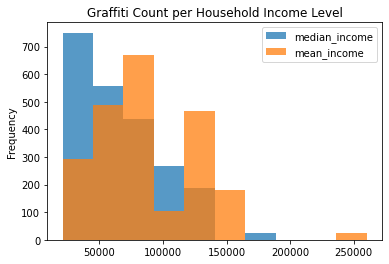

In [9]:
db[['median_income', 'mean_income']].plot(kind = 'hist', alpha = 0.75, title='Graffiti Count per Household Income Level')

There's an upwards trend as the mean/median ratio increases, though there's a massive amount of data at 1.25ish. 

In [10]:
db['ratio'] = db['mean_income']/db['median_income'] 

<AxesSubplot:title={'center':'graffiti count and median : mean income ratio'}, ylabel='Frequency'>

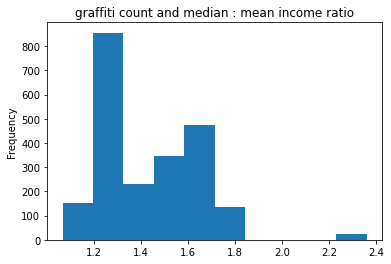

In [11]:
db['ratio'].plot(kind = 'hist', title = 'graffiti count and median : mean income ratio')

##**Income vs Graffiti Density**
In an aim to reduce the effect of large tracts with large numbers of graffitos, I've charted the density over income. The linear regressions show that graffiti density decreases as mean and median income increases, and graffiti density increases as income disparity (as represented by mean/median income ratio) increases.


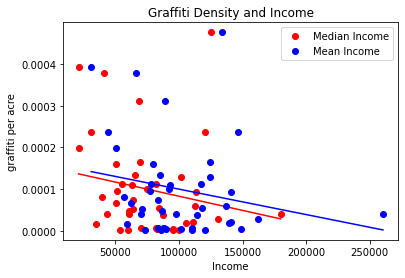

In [12]:
#Income Level

med_df = db[['AREALAND','median_income']].value_counts().reset_index().rename(columns={0:'graffiti_count'}).sort_values('median_income')#Makes a database with graffit counts associated with median income and land area
med_df = med_df.groupby('median_income')[['AREALAND','graffiti_count']].sum().reset_index() #Sums up area and graffiti count per median income 
med_df['density'] = med_df.graffiti_count / med_df.AREALAND #Creates a density value of count/acre grouped in each income value

mean_df = db[['AREALAND','mean_income']].value_counts().reset_index().rename(columns={0:'graffiti_count'}).sort_values('mean_income')#Makes a database with graffit counts associated with mean income and land area
mean_df = mean_df.groupby('mean_income')[['AREALAND','graffiti_count']].sum().reset_index() #Sums up area and graffiti count per mean income 
mean_df['density'] = mean_df.graffiti_count / mean_df.AREALAND #Creates a density value of count/acre grouped in each income value

#Lines of best fit
a1, b1 = np.polyfit(med_df['median_income'], med_df['density'], 1)
a2, b2 = np.polyfit(mean_df['mean_income'], mean_df['density'], 1)

#plots
med_scatter = plt.plot(med_df['median_income'], med_df['density'], 'ro', label = 'Median Income')
med_line = plt.plot(med_df['median_income'], a1*med_df['median_income'] + b1, 'r')
mean_scatter = plt.plot(mean_df['mean_income'], mean_df['density'], 'bo', label = 'Mean Income')
mean_line = plt.plot(mean_df['mean_income'], a2*mean_df['mean_income'] + b2, 'b')

#labels
plt.ylabel('graffiti per acre')
plt.xlabel('Income')
plt.title('Graffiti Density and Income')
plt.legend()

plt.show()

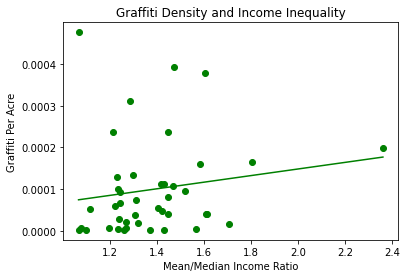

In [13]:
#Income Disparity
ratio_df = db[['AREALAND','ratio']].value_counts().reset_index().rename(columns={0:'graffiti_count'}).sort_values('ratio')#Makes a database with graffit counts associated with income ratio and land area
ratio_df = ratio_df.groupby('ratio')[['AREALAND','graffiti_count']].sum().reset_index() #Sums up area and graffiti count per income ratio 
ratio_df['density'] = ratio_df.graffiti_count / ratio_df.AREALAND #Creates a density value of count/acre grouped in each income ratio value

#Line of Best fit
a3, b3 = np.polyfit(ratio_df['ratio'], ratio_df['density'], 1)

#plots
plt.plot(ratio_df['ratio'], ratio_df['density'], 'go')
plt.plot(ratio_df['ratio'], a3*ratio_df['ratio'] + b3, 'g')

#labels
plt.ylabel('Graffiti Per Acre')
plt.xlabel('Mean/Median Income Ratio')
plt.title('Graffiti Density and Income Inequality')

plt.show()

###Removal


I hypothesised that increasing income would show an increase in graffiti removal. On the contrary, there is no graffiti removal in areas with incomes over $124,281. This is likely beacuse there is very little graffiti in these areas.

The first set of graphs are histograms showing the various states of graffiti removal by income level. The second is the % removal. 

In [14]:
canvas_location['GEOID_Tract'] = canvas_location['GEOID'].astype(str).str[:-1] #Creates a tract GEOID
removal = canvas_location.merge(acs, how = 'left', on = 'GEOID_Tract') #Canvas and ACS merge
removal = removal[['GEOID_Tract','median_income','removal']] #Just the important bits
rem_long = removal.melt(id_vars = 'median_income', value_vars = 'removal') #Long form for Seaborn

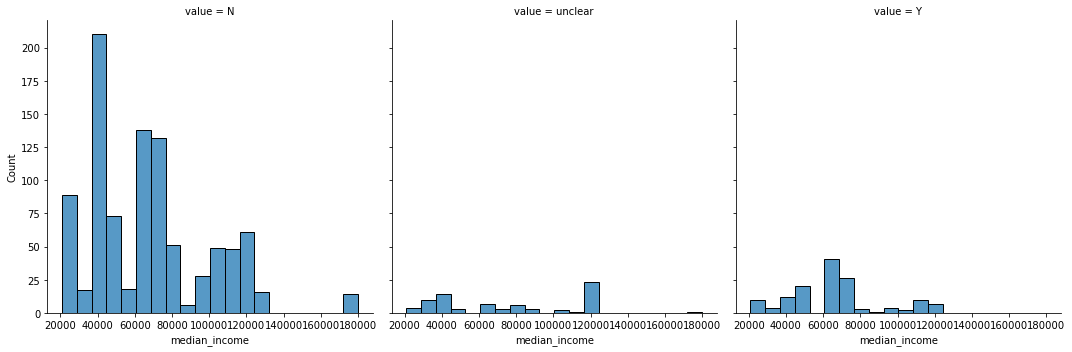

In [15]:
ax = sns.displot(data=rem_long, x='median_income', col='value')#.fig.suptitle('Graffiti Removal vs. Income')
#I can't make the title work well

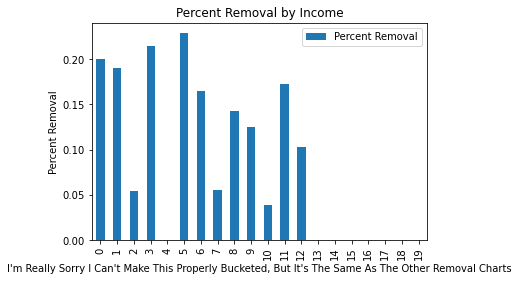

In [16]:
#Data preoprocessing for % removal by income
rem_no = rem_long.loc[rem_long.value == 'N'].median_income 
rem_yes = rem_long.loc[rem_long.value == 'Y'].median_income

#set up histogram bins
cut_bins = np.linspace(rem_long.median_income.min(),rem_long.median_income.max(),21)

#gets binned counts
no_count = pd.cut(rem_no, bins = cut_bins).value_counts().sort_index().reset_index()
yes_count = pd.cut(rem_yes, bins = cut_bins).value_counts().sort_index().reset_index()

#renames counts to usable names 
no_count = no_count.rename(columns = {'median_income':'Ns'})
yes_count = yes_count.rename(columns = {'median_income':'Ys'})

#creates a graphing df b/c boar charts weren't working
counts = pd.DataFrame([])
counts['Percent Removal'] = yes_count.Ys/(no_count.Ns+yes_count.Ys)#calculates % removal
#counts['Percent Removal'] = counts['Percent Removal'].fillna(0) #Fixes the divide by zero issue

#PLOTS
counts.plot(kind='bar')
plt.title('Percent Removal by Income')
plt.ylabel('Percent Removal')
plt.xlabel("I'm Really Sorry I Can't Make This Properly Bucketed, But It's The Same As The Other Removal Charts")

plt.show()

## Final submission



### Conclusions

I learned that graffiti count and density decrease as income increases, which agrees with the general concensus. Additionally, the marked increase in graffiti as the mean/median income ratio increased was an interesting obeservation that speaks to the difference that income inequality has on the proliferation of graffiti.

My expectation that graffiti removal would increase with income as incorrect, but that clearly seems to be more closely corrolated with graffiti density than actualy removal. This is interesting becuase it shows that graffiti removal ordances disproportionately impact lower income arees which can least afford the expense of removing the significant graffiti denisity in their areas.